cross entropy loss ( cse2 )　分類問題

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 4.3 MB/s 


In [6]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

データ読み込み

In [8]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


DataSetとDataLoaderの生成

In [ ]:
"""
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

# indexを指定すればデータを取り出すことができます。
index = 0
print( train_dataset.__getitem__(index)[0].size() )
print( train_dataset.__getitem__(index)[1] )


batch_size = 112
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
# こんな感じでバッチ単位で取り出す子ができます。
# イテレータに変換
batch_iterator = iter(train_dataloader)

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels.size())
print(inputs)
print(labels)
"""

トレーニング用のデータを作成する

In [9]:
batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]

torch.Size([112, 4])
torch.Size([112])


ニューラルネットワークの定義

In [10]:
class Net1(nn.Module):    
    def __init__(self,t):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 3)
        self.target = t
    
    def forward(self, x):
        self.x2 = F.relu(self.fc1(x))
        x = self.fc2(self.x2)
        
        #print(x);
        self.out = x

        loss = nn.CrossEntropyLoss()
        output = loss( x, self.target )
        return output

class Net(nn.Module):    
    def __init__(self,t):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
        self.target = t
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        self.out = x

        loss = nn.CrossEntropyLoss()
        output = loss( x, self.target )
        return output

計算グラフをJSONファイルに出力する

In [11]:
def generate_json( json_path, input, target ):

    model = Net( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [12]:
torch.manual_seed( 1 )

inputs.requires_grad = True

project = 'cse2'
json_path = './network/' + project +'.json'

model = generate_json( json_path, inputs, labels )

[SAVE] ./network/cse2.json
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc2]/weight/fc2
skip: Net/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [13]:
folder = "./cse"
CV.convert_cpp_code( project, folder, model, inputs, json_path )

[JSON] ./network/cse2.json
{'name': 'Net/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
[PARAM] ./cse/cse2_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [16, 4], 'out': [3], 'sorted_id': 0}
{'name': 'Net/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
Net/Linear[fc1]/weight/weight.5  ->  fc1_weight
{'name': 'Net/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}

In [14]:
#check code
with torch.set_grad_enabled(True):

  output = model( inputs )
  print("output",output)
 
  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.1592, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[ 0.0079,  0.0019, -0.0074,  0.0033],
        [-0.0021, -0.0022,  0.0022, -0.0113],
        [-0.0104, -0.0041,  0.0029, -0.0023],
        [-0.0019, -0.0027,  0.0018, -0.0109],
        [ 0.0037,  0.0060, -0.0038,  0.0043],
        [-0.0087, -0.0035,  0.0027, -0.0036],
        [ 0.0082, -0.0002,  0.0105,  0.0011],
        [ 0.0088, -0.0003,  0.0081,  0.0020],
        [ 0.0094,  0.0071, -0.0013,  0.0001],
        [ 0.0053,  0.0079, -0.0060,  0.0067],
        [ 0.0082,  0.0077, -0.0035,  0.0039],
        [ 0.0060, -0.0081,  0.0073, -0.0040],
        [-0.0101, -0.0004,  0.0010, -0.0013],
        [-0.0088, -0.0035,  0.0026, -0.0035],
        [ 0.0066,  0.0038, -0.0010,  0.0024],
        [-0.0101, -0.0040,  0.0023, -0.0024]])
Train Loss 1: 1.1592 Acc: 0.1250


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


C++コードをコンパイルする

In [16]:
!g++ -std=c++14 ./cse/cse2.cpp ./cse/cse2_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./cse/cse2

In [18]:
!./cse/cse2

### forward computation ...
 1.159191
### backward computation ...
input_grad{{ 0.007852,  0.001863, -0.00743 ,  0.003316},
 {-0.002147, -0.00224 ,  0.002238, -0.011295},
 {-0.010359, -0.004133,  0.002899, -0.002324},
 {-0.00189 , -0.002692,  0.001823, -0.010877},
 { 0.003715,  0.005978, -0.003784,  0.004317},
 {-0.008726, -0.003455,  0.00269 , -0.003556},
 { 0.008221, -0.000226,  0.010522,  0.001093},
 { 0.008813, -0.000263,  0.008063,  0.001997},
 { 0.009443,  0.007127, -0.001275,  0.00012 },
 { 0.005308,  0.007935, -0.005981,  0.00668 },
 { 0.008194,  0.007653, -0.003538,  0.003874},
 { 0.006027, -0.008148,  0.007274, -0.003992},
 {-0.010132, -0.000435,  0.000989, -0.001342},
 {-0.008782, -0.003494,  0.002566, -0.003531},
 { 0.006593,  0.003767, -0.000976,  0.002395},
 {-0.010092, -0.004035,  0.00226 , -0.002399}}


学習の実行(python版)

In [20]:
torch.manual_seed( 1 )
#inputs.requires_grad = True

model = Net( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []

for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += loss;

        # 正解数の合計を更新
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

batch 7 112 16
Train Loss 0: 7.5855 Acc: 0.2143 24
Train Loss 1: 6.6945 Acc: 0.4107 46
Train Loss 2: 6.0157 Acc: 0.6696 75
Train Loss 3: 5.5105 Acc: 0.6786 76
Train Loss 4: 5.1288 Acc: 0.7054 79
Train Loss 5: 4.8244 Acc: 0.7054 79
Train Loss 6: 4.5905 Acc: 0.7232 81
Train Loss 7: 4.3828 Acc: 0.7232 81
Train Loss 8: 4.2135 Acc: 0.7589 85
Train Loss 9: 4.0561 Acc: 0.7768 87
Train Loss 10: 3.9315 Acc: 0.7768 87
Train Loss 11: 3.8134 Acc: 0.7857 88
Train Loss 12: 3.7021 Acc: 0.8125 91
Train Loss 13: 3.6081 Acc: 0.8214 92
Train Loss 14: 3.5189 Acc: 0.8304 93
Train Loss 15: 3.4388 Acc: 0.8214 92
Train Loss 16: 3.3620 Acc: 0.8304 93
Train Loss 17: 3.2986 Acc: 0.8304 93
Train Loss 18: 3.2300 Acc: 0.8304 93
Train Loss 19: 3.1694 Acc: 0.8393 94
Train Loss 20: 3.1126 Acc: 0.8393 94
Train Loss 21: 3.0580 Acc: 0.8393 94
Train Loss 22: 3.0088 Acc: 0.8393 94
Train Loss 23: 2.9600 Acc: 0.8482 95
Train Loss 24: 2.9159 Acc: 0.8661 97
Train Loss 25: 2.8710 Acc: 0.8661 97
Train Loss 26: 2.8340 Acc: 0.8750

収束状況グラフを描画する

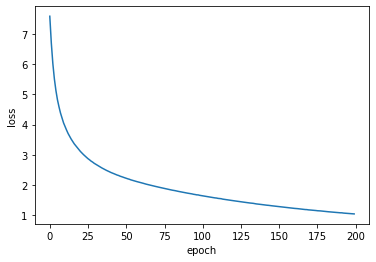

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率グラフを描画する

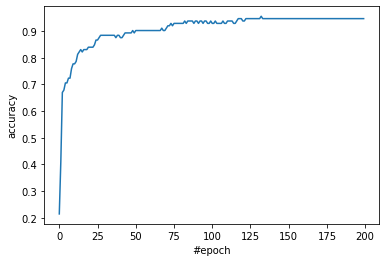

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

学習用データファイル、学習ループのC++コードを生成する

In [23]:
CV.convert_data_file( project, folder, inp_data=x_train, labels=y_train )
CV.convert_train_code( project, folder, json_path, sol="cse", inp_data=x_train, batch=16 )

datafile key :  inp_data
datafile key :  labels
[DATA] ./cse/cse2_data.cpp
[JSON] ./network/cse2.json
epoch_num :  200
batch_size :  16
lr :  0.01
inp shape (112, 4) 2
inp  shape :  1 {112,4}
pred shape :  0 
target shape :  0 
div :  False
cse_no :  7 8
batch_size: 16
inp_shape: {112,4}
cse_no :  13
unpack0 aten::linear
unpack original no:  7 7
[TRAIN]  ./cse/cse2_train.cpp


学習用C++コードをコンパイル、リンクする

In [24]:
!g++ -std=c++14 ./cse/cse2_train.cpp ./cse/cse2_param.cpp ./cse/cse2.cpp ./cse/cse2_data.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./cse/cse2_train

In [25]:
! ./cse/cse2_train

epoch_num : 200
indata shape   : 112,4
batch  number  : 7,16
learning ratio : 0.01
total_loss : epoch 0 : loss 7.59747 : Acc 0.232143 26
total_loss : epoch 1 : loss 6.68911 : Acc 0.428571 48
total_loss : epoch 2 : loss 6.01165 : Acc 0.678571 76
total_loss : epoch 3 : loss 5.51685 : Acc 0.678571 76
total_loss : epoch 4 : loss 5.1305 : Acc 0.696429 78
total_loss : epoch 5 : loss 4.82747 : Acc 0.705357 79
total_loss : epoch 6 : loss 4.58435 : Acc 0.714286 80
total_loss : epoch 7 : loss 4.38152 : Acc 0.732143 82
total_loss : epoch 8 : loss 4.21414 : Acc 0.741071 83
total_loss : epoch 9 : loss 4.05858 : Acc 0.785714 88
total_loss : epoch 10 : loss 3.92594 : Acc 0.785714 88
total_loss : epoch 11 : loss 3.81016 : Acc 0.785714 88
total_loss : epoch 12 : loss 3.70184 : Acc 0.803571 90
total_loss : epoch 13 : loss 3.61093 : Acc 0.821429 92
total_loss : epoch 14 : loss 3.51931 : Acc 0.821429 92
total_loss : epoch 15 : loss 3.44225 : Acc 0.821429 92
total_loss : epoch 16 : loss 3.364 : Acc 0.82142

In [27]:
# read output file from c++ code
f = open('./cse/cse2.out', 'r')

loss = []
acc  = []
datalist = f.readlines()
for data in datalist:
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )
f.close()

print("epoch =", len(loss))
print( loss )
print( acc )

epoch = 200
[7.597468, 6.689106, 6.011647, 5.51685, 5.130503, 4.827466, 4.584351, 4.381521, 4.214136, 4.05858, 3.925942, 3.810159, 3.701838, 3.61093, 3.519312, 3.442245, 3.363999, 3.292777, 3.230877, 3.171432, 3.111919, 3.056591, 3.01118, 2.958789, 2.914232, 2.871661, 2.832318, 2.796855, 2.755505, 2.723965, 2.687866, 2.658062, 2.625632, 2.595283, 2.566226, 2.539409, 2.513676, 2.486178, 2.462165, 2.440466, 2.415137, 2.395655, 2.370834, 2.353388, 2.335214, 2.314443, 2.292734, 2.275933, 2.255724, 2.238507, 2.220716, 2.205108, 2.191712, 2.171688, 2.160423, 2.143305, 2.127724, 2.116499, 2.097202, 2.085668, 2.069206, 2.056327, 2.043824, 2.030543, 2.016034, 2.002995, 1.990911, 1.979242, 1.965521, 1.956728, 1.941037, 1.932077, 1.918055, 1.907985, 1.895702, 1.883829, 1.875113, 1.863097, 1.852475, 1.84695, 1.832355, 1.823963, 1.809535, 1.801409, 1.79319, 1.781885, 1.770624, 1.761572, 1.752739, 1.742282, 1.732366, 1.722372, 1.71431, 1.703827, 1.698264, 1.68669, 1.676717, 1.66601, 1.661466, 1.6515

収束状況グラフを描画する

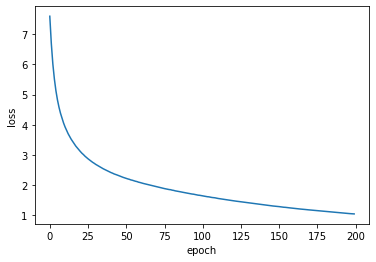

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率グラフを描画する

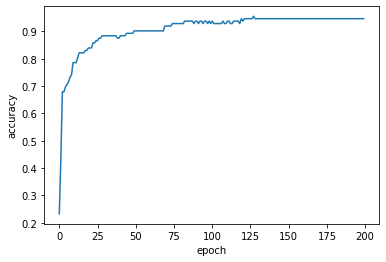

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()